In [1]:
#hide
from utils import *
hc(
    "On Musical Onset Detection via the S-Transform",
    ["stockwell trasform", "cubic spline"],
    "https://arxiv.org/pdf/1712.02567"
)

# Overview

Given a song, the task is to find its tempo (BPM) and beats position.
- Input:
    - Audio signal
    - Sampling rate
- Output:
    - Tempo
    - Beat location

# Intro
A beat/onset is sudden burst of energy occuring at regular time intervals, allowing us to anticipate, and tap along with the music.

In this notebook, we make an attempt to detect beats/onsets location of a song using a feature representation known as the *S-Transform*. While there are many other ways for beat detection, this one is quite unique in its approach, most existing techniques rely on the *STFT* (another feature representation) instead.

The implementation is provided in two parts as per mentioned in the paper:
- **Algorithm 1**: Detecting onset envelopes using band spliting
- **Algorithm 2**: Isolating onset envelopes.

At the end, we also pack the implementation in a user-friendly API.

# Algorithm 1 - Onset Envelopes By Band Splitting

## Loading Audio Signal

We load a $4$ second audio clip from a song at a sampling rate of $44100$ Hz. The clip is chosen to have percussive elements presence.

In [1]:
#hide
# Utility functions
def spectrogram(y, sr, N, H, gamma=None):
    """
    Compute magnitude spectrogram.

    Parameters
    ----------
    y: ndarray
        Signal.
    N: int
        - Number of fft bins (samples).
        - window length is same.
    H: int
        - Hop length (samples).
    gamma: int
        - Log compression factor
        
    Returns
    -------
    ndarray
        2D spectrogram matrix.
    ndarray
        1D frequency axis.
    ndarray
        1D time axis.
    """    
    import librosa
    S = librosa.stft(y=y, n_fft=N, win_length=N, hop_length=H, center=True, window="hann")
    S = np.abs(S)
    S_fr = sr / H # Frame rate (Hz)
    if gamma is not None:
        S = np.log(1 + gamma * S)
    S_f = np.arange(S.shape[0]) * (sr / N)
    S_t = np.arange(S.shape[1]) / S_fr

    return S, S_f, S_t

In [31]:
import modusa as ms
import numpy as np

SR = 44100 # Hz

# Load an audio signal

# audio_fp = "../../../data/srgm-music/Dhanda Nyoliwala - Russian Bandana.mp3" # 83
# x, sr, title = ms.load(audio_fp, sr=SR, clip=(20, 24))

audio_fp = "../../../data/samples/Sample Song.mp3"
x, sr, title = ms.load(audio_fp, sr=SR, clip=(70, 74))

## Downsampling

We compute $y[n]$, a downsampled version of $x[n]$ with a downsampling factor of $D = 40$.

$y[n] = x[nD]$

$M = \lfloor{1 + \frac{N-1}{D}} \rfloor$ is the length of $y$.

where,
- $\lfloor \cdot \rfloor$ is floor function (rounds down to the nearest integer)

In [32]:
D = 40 # Downsampling factor => sr = 1102.5 hz

y = x[::D]
sr = sr // D

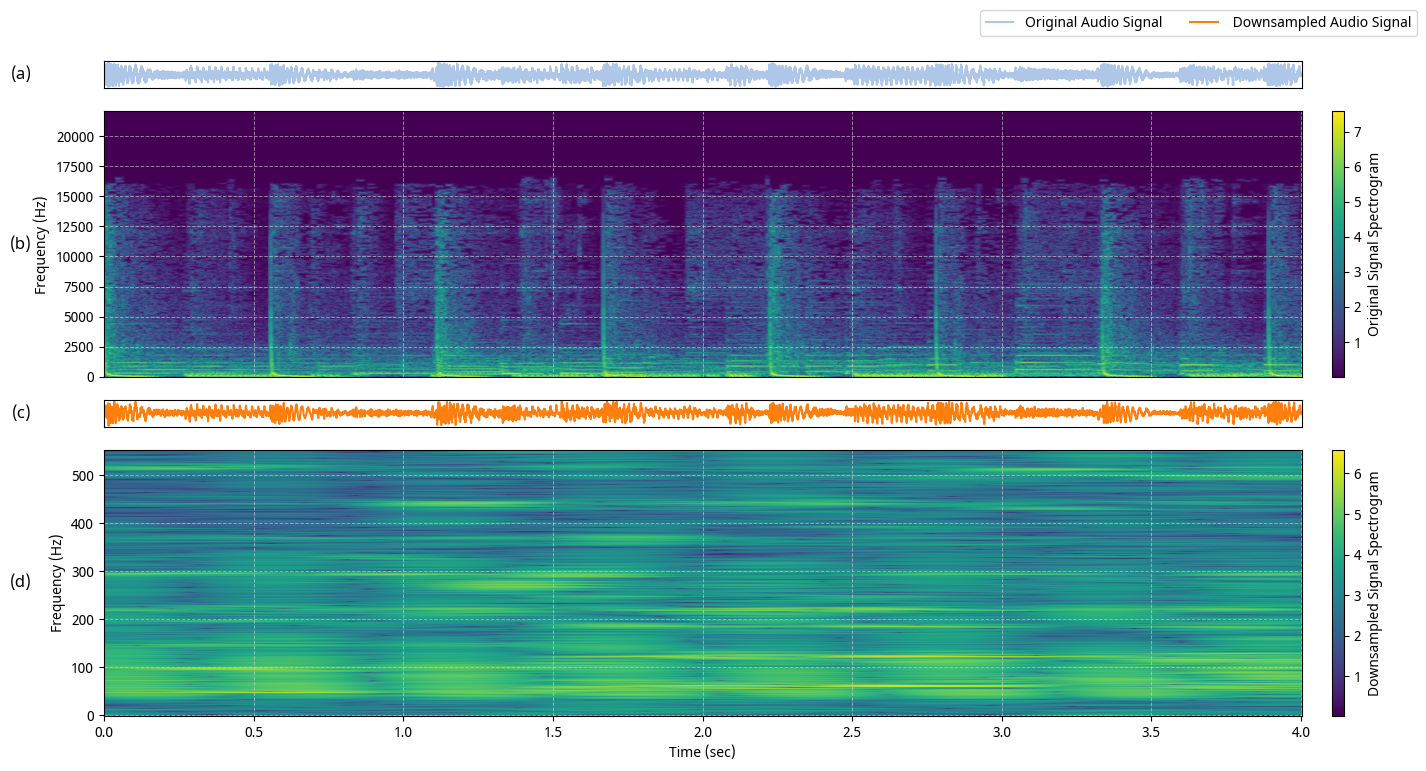

In [33]:
# Visualization
fig = ms.fig("amam", abc=True)
fig.add_signal(x, np.arange(x.size) / SR, label="Original Audio Signal", grid=False)
fig.add_matrix(*spectrogram(x, SR, 1024, 160, 10), o="lower", label="Original Signal Spectrogram", ylabel="Frequency (Hz)")

fig.add_signal(y, np.arange(y.size) / sr, label=" Downsampled Audio Signal", grid=False)
fig.add_matrix(*spectrogram(y, sr, 1024, 160 // D, 10), o="lower", label="Downsampled Signal Spectrogram", ylabel="Frequency (Hz)")

fig.add_xlabel("Time (sec)")
fig.add_legend(0.92)

Comparing (b), the spectrogram of the original signal (a), with (d), the spectrogram of the downsampled signal (c), we observe that the onset information, visible as vertical lines in (b) has completely disappeared in the latter due to the low sampling rate.

## Discrete Fourier Transform

As per the paper, we are supposed to compute the DFT $Y[k]$ of the downsampled signal $y[n]$ which will be used to compute the S-Transform in the next step. But, we will be using a python library to compute the S-Transform and thus not need this step.

$Y[k] = \frac{1}{M} \sum_{n=0}^{M-1}{y[n] \cdot e^{-j2\pi n k / M}}$

## Discrete S-Transform

$
F[p, n] =
\begin{cases}
\sum_{m=0}^{M-1} Y[m+n] \exp\left( \frac{j 2 \pi m p}{N} - \frac{2 \pi^2 m^2}{n^2} \right), & n \neq 0, \\[1.2em]
{\frac{1}{M} \sum_{m=0}^{M-1}{y[m]}}, & n = 0.
\end{cases}
$

where $n = 0, 1, 2, ..., M-1$ and $p = 0, 1, ..., \frac{M}{2} - 1$

The idea behind using S-Transform is to get a much better frequency resolution at lower frequencies unlike STFT. A naive implementation of the S-Transform has a complexity of $O(N^3)$, but more efficient algorithms reduce this to $O(N \log N)$. In this work, we use the Python library **stockwell** to compute the Discrete S-Transform (DST). Consequently, the previously computed $Y[k]$ is no longer required explicitly.

To learn more about DST, please check the appendix section.

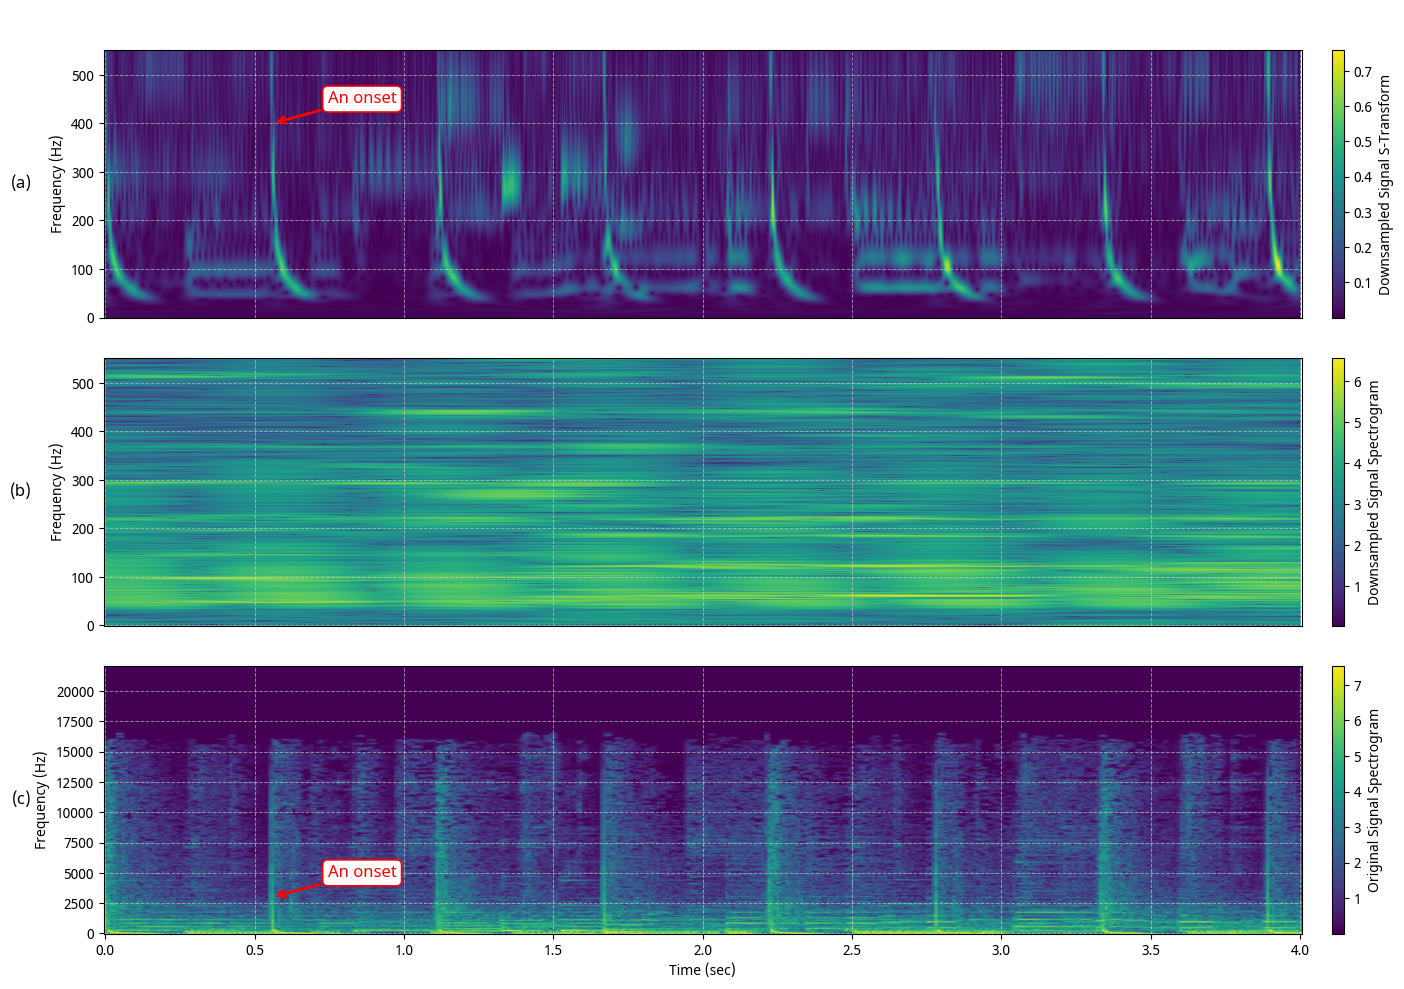

In [6]:
from stockwell import st

F = st.st(y, lo=0, hi=int(y.size/2)) # shape = (y.size / 2, y.size): S-Transform using the library
S = np.abs(F)
S_ts = np.arange(F.shape[1]) / sr
S_fs = np.linspace(0, sr / 2, F.shape[0])

# Visualization
fig = ms.fig("mmm", abc=True)
fig.add_matrix(np.abs(S), S_fs, S_ts, o="lower", label="Downsampled Signal S-Transform", ylabel="Frequency (Hz)")
fig.add_arrows((0.56, 400), "An onset", text_offset=(0.3, 50))
fig.add_matrix(*spectrogram(y, sr, 1024, 160 // D, 10), o="lower", label="Downsampled Signal Spectrogram", ylabel="Frequency (Hz)")
fig.add_matrix(*spectrogram(x, SR, 1024, 441, 10), o="lower", label="Original Signal Spectrogram", ylabel="Frequency (Hz)") # Plotting the spectrogram of original audio signal for analysis
fig.add_arrows((0.56, 3000), "An onset", text_offset=(0.3, 2000))
fig.add_xlabel("Time (sec)")

In (a), we see sharp vertical lines that align with the onset locations when compared to (c), the spectrogram of the original signal. Interestingly, while the spectrogram in (b) of the downsampled signal appears too blurred for reliable onset detection, the S-Transform applied to the same downsampled signal is still able to capture the onsets effectively.

## Band Splitting

Now, we split the $S$ matrix into subbands each of size $K$.

In [34]:
K = 200 # Subband size 200 bins ~ 50 hz

S_trim = S[:S.shape[0] - S.shape[0] % K, :] # Remove rows that don't fit into complete K-sized bands
S_blocks = S_trim.reshape(-1, K, N) # (band, freq, time)

print(f"S{S.shape} -> S_blocks{S_blocks.shape}")

S(2206, 4410) -> S_blocks(11, 200, 4410)


## Onset Envelope

We now compute onset envelope for each band by taking mean across the rows for each band.

In [35]:
r = np.zeros((S_blocks.shape[0], S_blocks.shape[2]))
I = np.ones(K)

for i in range(r.shape[0]):
    r[i] = np.mean(S_blocks[i], axis=0)

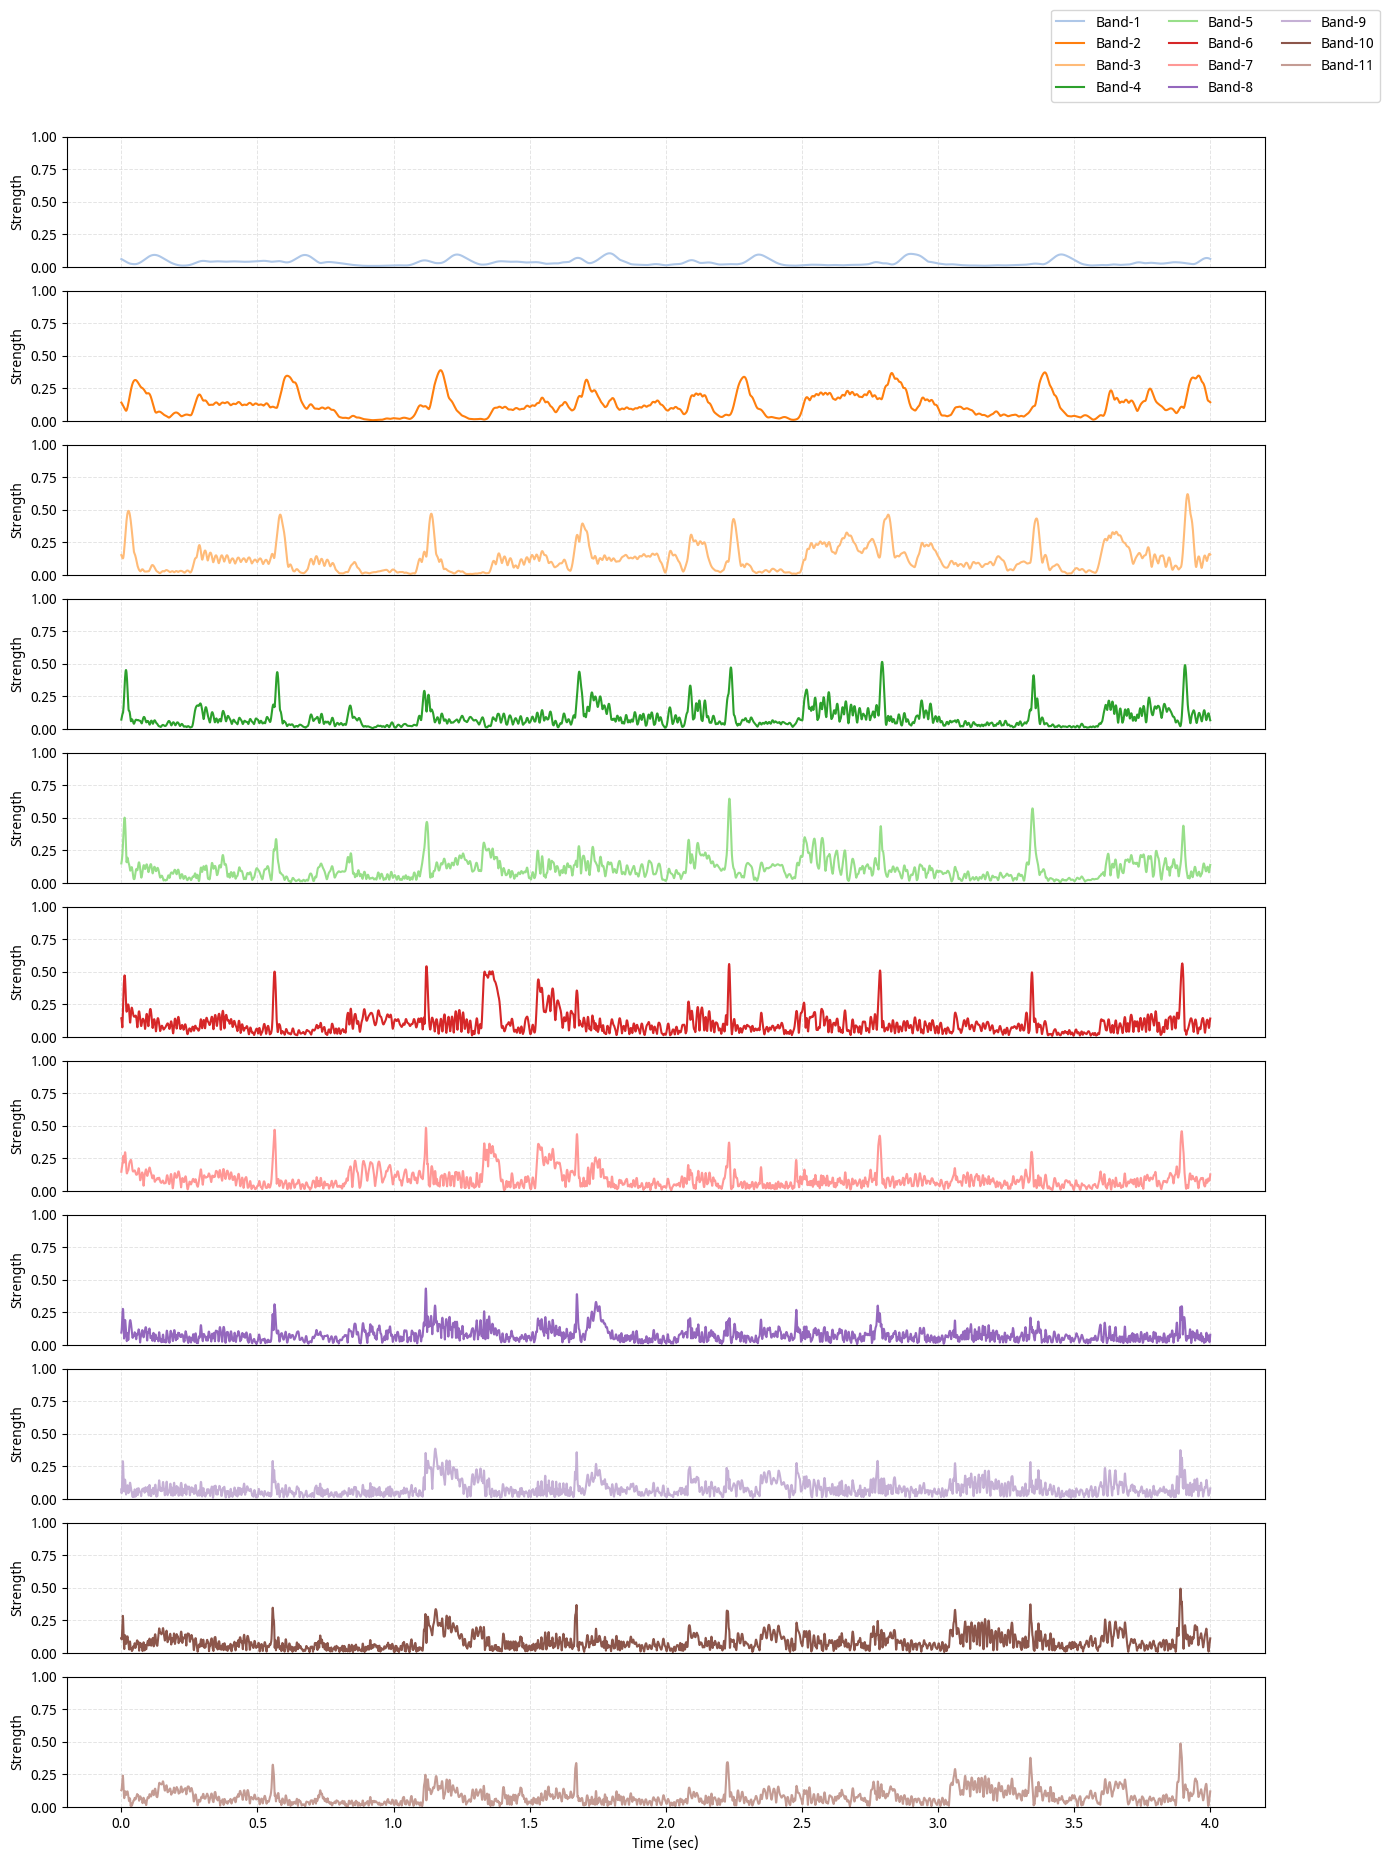

In [36]:
# Visualization
fig = ms.fig("s"*r.shape[0])
for i in range(r.shape[0]):
    fig.add_signal(r[i], np.arange(r.shape[1]) / sr, label=f"Band-{i+1}", ylim=(0, 1), ylabel="Strength")
fig.add_legend(0.93)
fig.add_xlabel("Time (sec)")

# Algorithm 2 - Onset Envelop Isolation

## Normalisation

We then normalize the onset envelope (aka ODF - Onset Detection Function) using the below equation.
$\bar{r_i} = r_i / ||r_i||_{\infty}$

This is also known as **max** norm changing the range of the ODF to $[0, 1]$

In [37]:
r_norm = np.zeros_like(r)
for i in range(r.shape[0]): # Go through each band onset envelope
    r_norm[i] = r[i] / np.max(np.abs(r[i]))

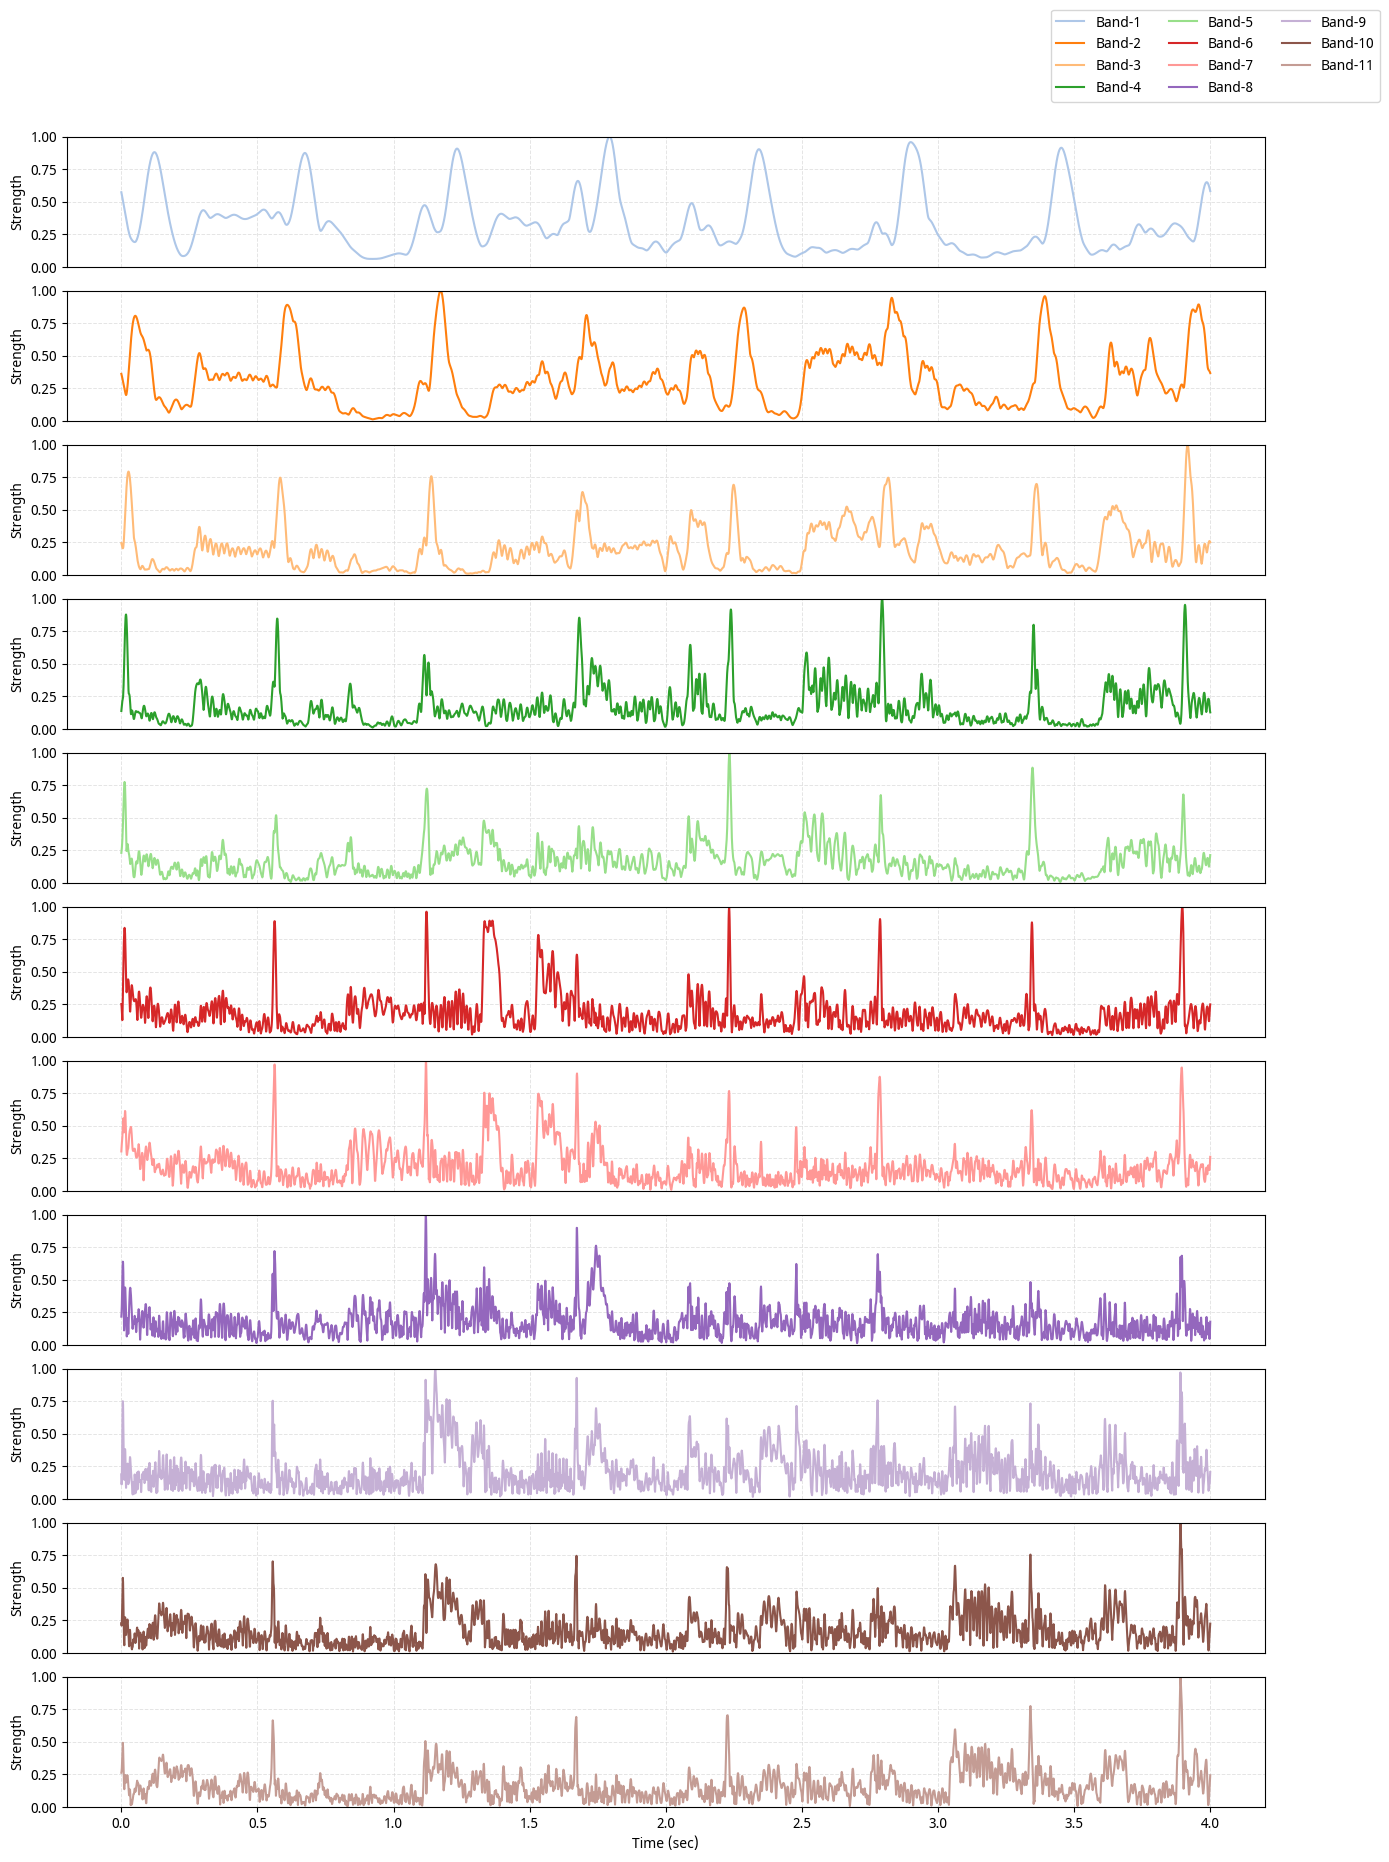

In [38]:
# Visualization
fig = ms.fig("s"*r_norm.shape[0])
for i in range(r_norm.shape[0]):
    fig.add_signal(r_norm[i], np.arange(r.shape[1]) / sr, label=f"Band-{i+1}", ylabel="Strength", ylim=(0, 1))
fig.add_legend(0.93)
fig.add_xlabel("Time (sec)")

## Upper Envelope Computation

We then try to get rid of unnecessary flucutuations in the ODF. To achieve that, we perform cubix spline interpolation to connect all the detected peaks.

In [39]:
from scipy.signal import find_peaks
from scipy.interpolate import CubicSpline

d = 1 # 1 sample
u = np.zeros_like(r_norm)

for band in range(r_norm.shape[0]): # For each of the bands
    peaks, _ = find_peaks(r_norm[band], distance=d)

    peak_indices = peaks
    peak_values = r_norm[band][peak_indices]

    cs = CubicSpline(peak_indices, peak_values)
    u[band] = cs(np.arange(len(r_norm[band])))

    if band == 0:
        peak_indices_band_0 = peak_indices # Storing this for showing an example

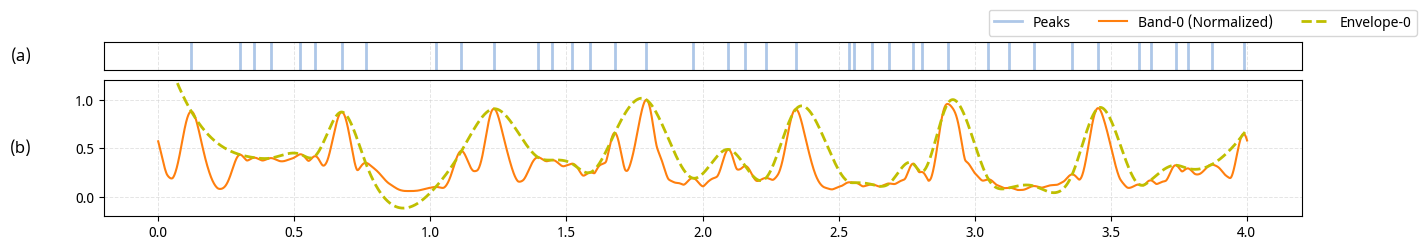

In [40]:
# Visualization
fig = ms.fig("as", abc=True)
fig.add_events(peak_indices_band_0 / sr, lw=2, label="Peaks")
fig.add_signal(r_norm[0], np.arange(r_norm[0].size) / sr, ylim=(-0.2, 1.2), label="Band-0 (Normalized)")
fig.add_signal(u[0], np.arange(u[0].size) / sr, c="y", ls="--", lw=2, ax=2, label="Envelope-0")
fig.add_legend()

## Centering

Using the upper envelope, we then center our ODF giving us a much cleaner ODF.

In [41]:
r_centered = np.zeros_like(r_norm)

for band in range(r_centered.shape[0]): # For each band
    r_centered[band] = np.maximum(r_norm[band] - np.mean(u[band]), 0)

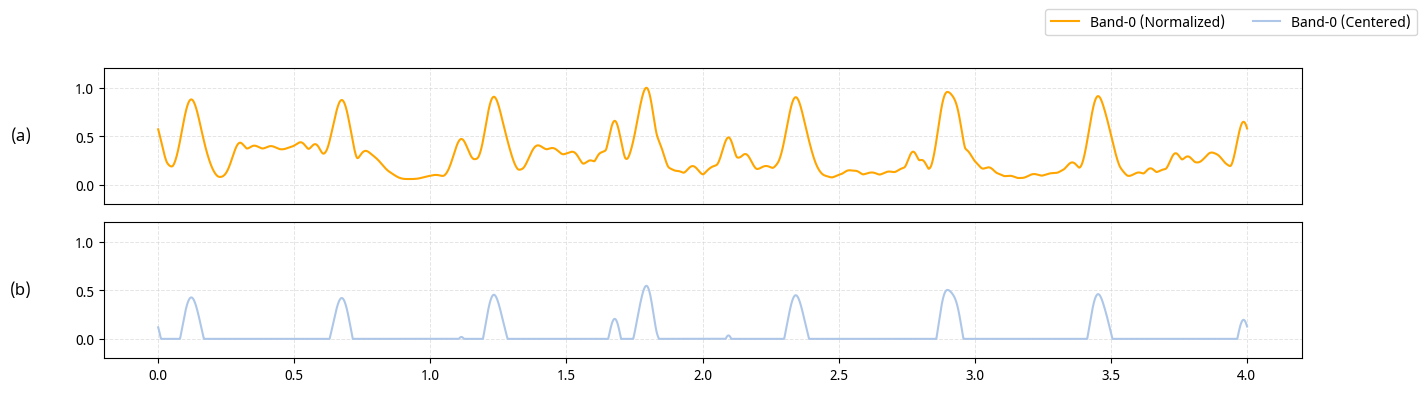

In [42]:
# Visualization
fig = ms.fig("ss", abc=True)
fig.add_signal(r_norm[0], np.arange(r_norm[0].size) / sr, ylim=(-0.2, 1.2), c="orange", label="Band-0 (Normalized)")
fig.add_signal(r_centered[0], np.arange(r_centered[0].size) / sr, ylim=(-0.2, 1.2), label="Band-0 (Centered)")
fig.add_legend()

## Thresholding and Clustering

This step is fairly complex, so we’ll break it down into smaller, manageable parts. For better understanding, we will stick to just one sub-band.

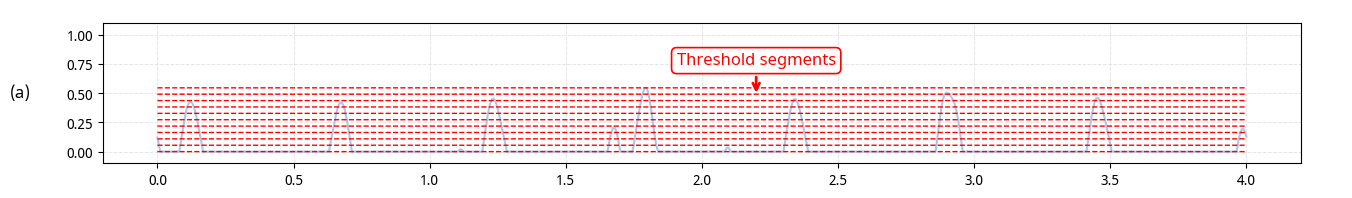

In [66]:
H = 10 # Divide the threshold into H segments between 0 and max(r_centered)

# We select a sub-band
selected_band = 0
selected_r = r_centered[selected_band]

# For the selected band, we divide thresholds into H segments
thresholds = np.linspace(0, np.max(selected_r), H+1)

fig = ms.fig("s", abc=True)
fig.add_signal(selected_r, np.arange(selected_r.size) / sr)
for threshold in thresholds:
    fig.add_signal(np.ones_like(selected_r) * threshold, np.arange(selected_r.size) / sr, ax=1, c="r", ls="--", lw=1, ylim=(-0.1, 1.1))
fig.add_arrows((2.2, 0.48), labels="Threshold segments", text_offset=(0, 0.3), c="r")

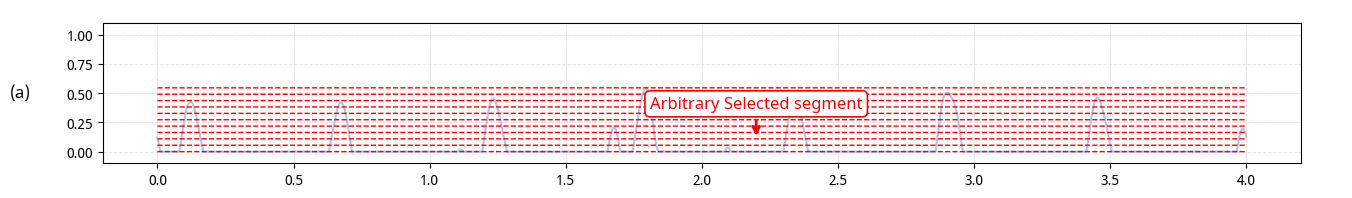

In [67]:
# We choose one of the threshold segments
selected_thresholds = 2 # Can go till len(thresholds) - 1

# For the selected segment, we take the threshold to be the lower bound for that segment
h = thresholds[selected_thresholds]

fig = ms.fig("s", abc=True)
fig.add_signal(selected_r, np.arange(selected_r.size) / sr)
for threshold in thresholds:
    fig.add_signal(np.ones_like(selected_r) * threshold, np.arange(selected_r.size) / sr, ax=1, c="r", ls="--", lw=1, ylim=(-0.1, 1.1))
    
fig.add_arrows((2.2, h), labels="Arbitrary Selected segment", text_offset=(0, 0.3), c="r")

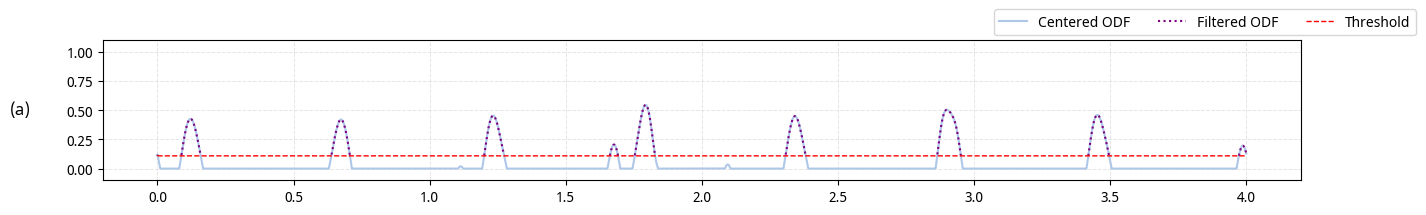

In [68]:
# For that selected segment, we now filter out all the indices where r_centered is greater than the threhold for that segment
I = np.where(selected_r >= h)[0] # These are all the filtered sample points

# Visualization
filtered_r = np.ones_like(selected_r) * np.nan
filtered_r[I] = selected_r[I]

fig = ms.fig("s", abc=True)
fig.add_signal(selected_r, np.arange(selected_r.size) / sr, label="Centered ODF")
fig.add_signal(filtered_r, np.arange(filtered_r.size) / sr, c="purple", ls=":", ax=1, label="Filtered ODF")

# Plotting the selected threshold region
fig.add_signal(np.ones_like(selected_r) * h, np.arange(selected_r.size) / sr, ax=1, c="r", ls="--", lw=1, ylim=(-0.1, 1.1), label="Threshold")
fig.add_legend()

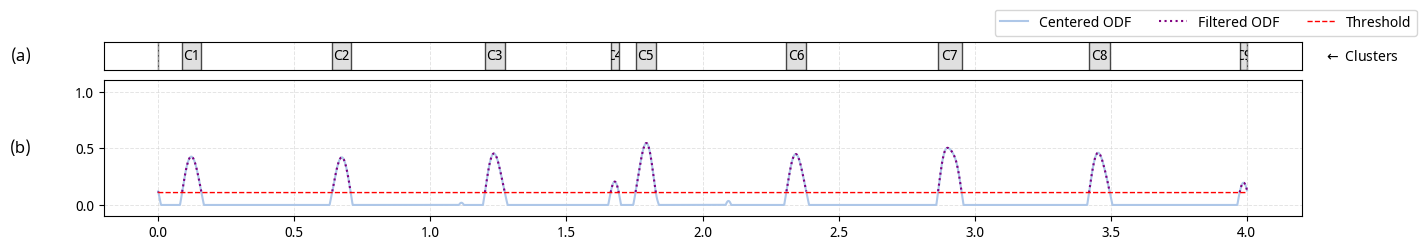

In [69]:
# Now we find contiguous clusters for filtered indices
C = [[I[0]]] # List of clusters
for x in I[1:]:
    if x == C[-1][-1] + 1:
        C[-1].append(x)
    else:
        C.append([x])
C = [np.array(c) for c in C]

# Visualization
C_ann = [(c[0] / sr, c[-1] / sr, f"C{i}") for i, c in enumerate(C)] # An annotation for visualizing clusters

fig = ms.fig("as", abc=True)
fig.add_annotation(C_ann, label="$\\leftarrow$ Clusters")
fig.add_signal(selected_r, np.arange(selected_r.size) / sr, label="Centered ODF")
fig.add_signal(filtered_r, np.arange(filtered_r.size) / sr, c="purple", ls=":", ax=2, label="Filtered ODF")

# Plotting the selected threshold region
fig.add_signal(np.ones_like(selected_r) * h, np.arange(selected_r.size) / sr, ax=2, c="r", ls="--", lw=1, ylim=(-0.1, 1.1), label="Threshold")
fig.add_legend()

Basis the threshold in (b), a few smaller peaks (cluster C4 and C9) are also being picked up. Leveraging the fact that musical beats occur at regular time interval, we must find a threshold that best aligns with this regularity. 

We take the center of each cluster as its location.

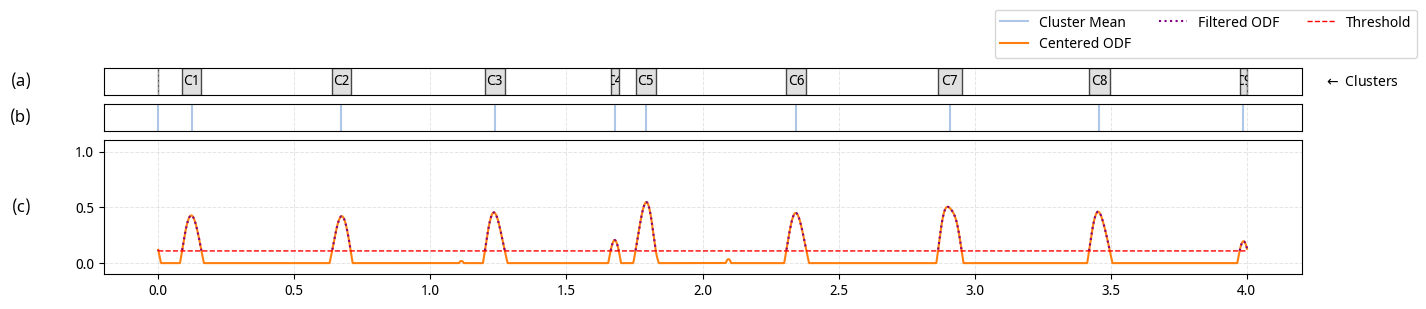

In [70]:
# Now we find the mean for each clusters
C_mean = [np.mean(c) for c in C]

# Visualization
fig = ms.fig("aas", abc=True)
fig.add_annotation(C_ann, label="$\\leftarrow$ Clusters")
fig.add_events([c / sr for c in C_mean], label="Cluster Mean")
fig.add_signal(selected_r, np.arange(selected_r.size) / sr, label="Centered ODF")
fig.add_signal(filtered_r, np.arange(filtered_r.size) / sr, c="purple", ls=":", ax=3, label="Filtered ODF")

# Plotting the selected threshold region
fig.add_signal(np.ones_like(selected_r) * h, np.arange(selected_r.size) / sr, ax=3, c="r", ls="--", lw=1, ylim=(-0.1, 1.1), label="Threshold")
fig.add_legend(1.08)

(b) marks the center time position of each cluster, now the task is to find out the difference between corresponding clusters' centre.

In [71]:
# We find the difference between consecutive clusters and normalize it
cluster_gap_vec = np.diff(C_mean)
cluster_gap_vec_normalized = np.sum(cluster_gap_vec) / (np.linalg.norm(cluster_gap_vec) * np.sqrt(cluster_gap_vec.size))

In [72]:
60 / np.mean(cluster_gap_vec / sr)

np.float64(135.44554455445547)

The next step is to find which of the (band, threshold) pair gives us the most stable beats. We first try to find which threshold is better.

In [30]:
for h in thresholds:

    # For that selected segment, we now filter out all the indices where r_centered is greater than the threhold for that segment
    I = np.where(selected_r >= h)[0] # These are all the filtered sample points
    
    # Visualization
    filtered_r = np.ones_like(selected_r) * np.nan
    filtered_r[I] = selected_r[I]
    
    # Now we find contiguous clusters for filtered indices
    C = [[I[0]]] # List of clusters
    for x in I[1:]:
        if x == C[-1][-1] + 1:
            C[-1].append(x)
        else:
            C.append([x])
    C = [np.array(c) for c in C]
    
    # Now we find the mean for each clusters
    C_mean = [np.mean(c) / sr for c in C]

    if len(C_mean) < 3: # Less than 3 clusters, there is no point finding how consistent the spacing are.
        continue
    
    # We find the difference between consecutive clusters and normalize it
    cluster_gap_vec = np.diff(C_mean)
    cluster_gap_vec_normalized = np.sum(cluster_gap_vec) / (np.linalg.norm(cluster_gap_vec) * np.sqrt(cluster_gap_vec.size))
    print(h, cluster_gap_vec_normalized)

0.05466060387373758 0.9282213479416892
0.10932120774747515 0.928540633028846
0.16398181162121273 0.9580585310365789
0.2186424154949503 0.999950297923372
0.2733030193686879 0.9999456771493668
0.32796362324242545 0.999946894470697
0.38262422711616306 0.9999491317852354
0.4372848309899006 0.9999441392235549


For the selected band, we see that the most stable beats are detected at a threshold of $0.2186$. But we should be doing it for all the band and get a list of 

In [45]:
r_centered.shape[0]

11

In [48]:
for current_band in range(r_centered.shape[0]):

    selected_band = current_band
    selected_r = r_centered[selected_band]
    print(f"Current band: {selected_band}")
    
    # For the selected band, we divide thresholds into H segments
    thresholds = np.linspace(0, np.max(selected_r), H+1)

    for i, h in enumerate(thresholds):
    
        # For that selected segment, we now filter out all the indices where r_centered is greater than the threhold for that segment
        I = np.where(selected_r >= h)[0] # These are all the filtered sample points
        
        # Visualization
        filtered_r = np.ones_like(selected_r) * np.nan
        filtered_r[I] = selected_r[I]
        
        # Now we find contiguous clusters for filtered indices
        C = [[I[0]]] # List of clusters
        for x in I[1:]:
            if x == C[-1][-1] + 1:
                C[-1].append(x)
            else:
                C.append([x])
        C = [np.array(c) for c in C]
        
        # Now we find the mean for each clusters
        C_mean = [np.mean(c) / sr for c in C]
    
        if len(C_mean) < 3: # Less than 3 clusters, there is no point finding how consistent the spacing are.
            continue
        
        # We find the difference between consecutive clusters and normalize it
        cluster_gap_vec = np.diff(C_mean)
        cluster_gap_vec_normalized = np.sum(cluster_gap_vec) / (np.linalg.norm(cluster_gap_vec) * np.sqrt(cluster_gap_vec.size))
        print(f"---> Threshold {i}: {h:.4f}, Uniformity: {cluster_gap_vec_normalized:.4f}")

Current band: 0
---> Threshold 1: 0.0547, Uniformity: 0.9282
---> Threshold 2: 0.1093, Uniformity: 0.9285
---> Threshold 3: 0.1640, Uniformity: 0.9581
---> Threshold 4: 0.2186, Uniformity: 1.0000
---> Threshold 5: 0.2733, Uniformity: 0.9999
---> Threshold 6: 0.3280, Uniformity: 0.9999
---> Threshold 7: 0.3826, Uniformity: 0.9999
---> Threshold 8: 0.4373, Uniformity: 0.9999
Current band: 1
---> Threshold 1: 0.0627, Uniformity: 0.8237
---> Threshold 2: 0.1254, Uniformity: 0.7610
---> Threshold 3: 0.1881, Uniformity: 0.8349
---> Threshold 4: 0.2508, Uniformity: 0.9652
---> Threshold 5: 0.3135, Uniformity: 0.9998
---> Threshold 6: 0.3762, Uniformity: 0.9998
---> Threshold 7: 0.4388, Uniformity: 0.9481
---> Threshold 8: 0.5015, Uniformity: 0.8699
---> Threshold 9: 0.5642, Uniformity: 0.8967
Current band: 2
---> Threshold 1: 0.0752, Uniformity: 0.8520
---> Threshold 2: 0.1505, Uniformity: 0.7516
---> Threshold 3: 0.2257, Uniformity: 0.8556
---> Threshold 4: 0.3010, Uniformity: 1.0000
---> Th

In [25]:
def onset_envelope_isolation(r, H=10):
    """
    Parameters
    ----------
    r: ndarray (band X freq X time)
        - Onset detection function.
    H: int
        - Number of threshold segments.

    Returns
    -------
    
    """

    H = 10 # Divide the threshold into H segments between 0 and max(r_centered)

    bi = []
    
    for band in range(r_centered.shape[0]): # Go through each band
        vij = []
        r_band = r_centered[band]
        
        # For the selected band, we divide thresholds into H segments
        thresholds = np.linspace(0, np.max(r_band), H+1)

        # Now we loop over the thresholds
        for segment in range(H):
            h = thresholds[segment]
            I = np.where(r_band >= h)[0] # These are all the filtered sample points
            if I.size == 0:
                continue
            
            # Now we find contiguous clusters for filtered indices
            C = [[I[0]]] # List of clusters
            for x in I[1:]:
                if x == C[-1][-1] + 1:
                    C[-1].append(x)
                else:
                    C.append([x])
            C = [np.array(c) for c in C]

            # Now we find the mean for each clusters
            C_mean = [np.mean(c) for c in C]
            print("band:", band, "threshold:", h)
            print(C_mean)

            # We find the difference between consecutive clusters and normalize it
            cluster_gap_vec = np.diff(C_mean)

            if cluster_gap_vec.size == 0 or np.all(cluster_gap_vec == 0) or np.any(np.isnan(cluster_gap_vec)):
                continue  # skip invalid cases
            
            cluster_gap_vec_normalized = np.sum(cluster_gap_vec) / np.sqrt(np.sum((cluster_gap_vec ** 2)))
            vij.append(cluster_gap_vec_normalized)

        if len(vij) == 0:
            bi.append(np.nan)
        else:
            bi.append(np.max(vij))
    bi = np.array(bi)
    
    return bi

# Creating APIs

It's important to package the product as user-friendly APIs, making it easy for others to use or build upon.

In [3]:
class TempoDetector:

    def __init__(self, fp):
        self._fp = fp

    def get_tempo(self):
        """
        Returns tempo in BPM.
        """
        pass

In [4]:
tempo = TempoDetector.get_tempo("path/to/song")

# Notebook Contributors

Ankit Anand

# Appendix

## S Transform

[source](https://www.kurims.kyoto-u.ac.jp/~kyodo/kokyuroku/contents/pdf/2102-01.pdf)

In [ ]:
#hide
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp

def stockwell_transform(data, lo=0, hi=None):
    """
    Pure Python implementation of the Stockwell Transform.
    
    Parameters
    ----------
    data : array_like
        Input real-valued time series data
    lo : int, optional
        Lowest frequency index (default: 0)
    hi : int, optional
        Highest frequency index (default: len(data)//2)
    
    Returns
    -------
    result : ndarray
        Complex S-transform array with shape (n_freqs, n_times)
        where n_freqs = hi - lo + 1
    """
    data = np.asarray(data, dtype=np.float64)
    n = len(data)
    
    # Set default frequency range
    if hi is None:
        hi = n // 2
    
    n_freqs = hi - lo + 1
    
    # Initialize result array (complex)
    result = np.zeros((n_freqs, n), dtype=np.complex128)
    
    # Convert input to complex and compute mean
    h = np.fft.fft(data)
    mean_val = np.mean(data)
    
    # Apply Hilbert transform
    # Upper half-circle gets multiplied by 2
    # Lower half-circle gets set to 0
    # Real axis (DC and Nyquist) left alone
    l2 = (n + 1) // 2
    h[1:l2] *= 2.0
    h[l2:] = 0.0
    
    # Process each frequency
    for idx, freq in enumerate(range(lo, hi + 1)):
        if freq == 0:
            # DC component: just the mean
            result[idx, :] = mean_val
        else:
            # Create Gaussian window in frequency domain
            # The Gaussian is exp(-2*pi^2*m^2/n^2) where n is the frequency
            gauss_window = np.zeros(n, dtype=np.float64)
            
            # Compute Gaussian for positive and negative frequencies
            gauss_window[0] = np.exp(-2.0 * np.pi**2 * 0**2 / freq**2)
            l2 = n // 2 + 1
            for m in range(1, l2):
                g_val = np.exp(-2.0 * np.pi**2 * m**2 / freq**2)
                gauss_window[m] = g_val
                gauss_window[n - m] = g_val
            
            # Shift the FFT and multiply by Gaussian
            # This corresponds to G[i] = H[freq + i] * gauss[i]
            G = np.zeros(n, dtype=np.complex128)
            for i in range(n):
                k = freq + i
                if k >= n:
                    k -= n
                G[i] = h[k] * gauss_window[i]
            
            # Inverse FFT to get time-domain result
            result[idx, :] = np.fft.ifft(G)
    
    return result


def inverse_stockwell_transform(st_result, lo=0, hi=None, n=None):
    """
    Inverse Stockwell Transform.
    
    Parameters
    ----------
    st_result : ndarray
        S-transform output (n_freqs x n_times)
    lo : int
        Lowest frequency index used in forward transform
    hi : int, optional
        Highest frequency index used in forward transform
    n : int, optional
        Length of output signal (default: number of time points)
    
    Returns
    -------
    result : ndarray
        Reconstructed real-valued signal
    """
    n_freqs, n_times = st_result.shape
    
    if n is None:
        n = n_times
    if hi is None:
        hi = lo + n_freqs - 1
    
    # Sum across time for each frequency
    H = np.zeros(n, dtype=np.complex128)
    
    for idx, freq in enumerate(range(lo, hi + 1)):
        H[freq] = np.sum(st_result[idx, :])
    
    # Invert the Hilbert transform
    l2 = (n + 1) // 2
    H[1:l2] /= 2.0
    
    # Restore negative frequencies by conjugate symmetry
    l2 = n // 2 + 1
    for i in range(l2, n):
        H[i] = np.conj(H[n - i])
    
    # Inverse FFT
    result = np.fft.ifft(H)
    
    return np.real(result)

F_custom = stockwell_transform(y, 0, int(y.size/2))
F_custom_ts = np.arange(F_custom.shape[1]) / sr
F_custom_fs = np.linspace(0, y.size/2, F_custom.shape[0])

fig = ms.fig("mms")
fig.add_matrix(np.abs(F), fs, ts, o="lower")
fig.add_matrix(np.abs(F_custom), F_custom_fs, F_custom_ts, o="lower")
fig.add_signal(np.sum(np.abs(F), axis=0), ts)